In [217]:
from PIL import Image
import random
import math
import time
from IPython.display import display
from IPython.display import clear_output
from PIL import Image, ImageDraw , ImageFont

im_size = (240,240)
pastelColorPallet = [(27,133,184),(90,82,85),(85,158,131),(174,90,65),(195,203,113),(249,107,75),(249,167,143),(195,155,211),(161,126,111)]


In [231]:

def rotPnt(pnt,ang):
    rotY = getYrot(ang[1]) 
    rotX = getXrot(ang[0])
    rot_a = transformVec(rotY[0],rotY[1],rotY[2],rotX[0])
    rot_b = transformVec(rotY[0],rotY[1],rotY[2],rotX[1])
    rot_c = transformVec(rotY[0],rotY[1],rotY[2],rotX[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out

def getYrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (math.cos(ang),0.0,math.sin(ang))
    yhat = (0.0,1.0,0.0)
    zhat = (-math.sin(ang),0.0,math.cos(ang))
    return (xhat,yhat,zhat)
    
def getXrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (1.0,0.0,0.0)
    yhat = (0.0,math.cos(ang),-math.sin(ang))
    zhat = (0.0,math.sin(ang),math.cos(ang))
    return (xhat,yhat,zhat)
    
def transformVec(xhat,yhat,zhat,pnt):
    out_x = xhat[0]*pnt[0]+yhat[0]*pnt[1]+zhat[0]*pnt[2]
    out_y = xhat[1]*pnt[0]+yhat[1]*pnt[1]+zhat[1]*pnt[2]
    out_z = xhat[2]*pnt[0]+yhat[2]*pnt[1]+zhat[2]*pnt[2]
    #print((out_x,out_y,out_z))
    return (out_x,out_y,out_z)
    
def Dot_2d(a,b):
    return (a[0]*b[0] + a[1]*b[1])

def getperpendicular_clock(a):
    return (a[1],-a[0])

def posPnt(pnt,pos):
    return((pnt[0]+pos[0],pnt[1]+pos[1],pnt[2]+pos[2]))

def verticeToScreen(vertice,ang,pos,screen_size):
    pnt = rotPnt(vertice,ang)
    pnt = posPnt(pnt,pos)
    FOV = math.radians(60)
    screenHeightWorld = math.tan(FOV/2)*2
    pixelsPerUnitWorld = screen_size[1]/screenHeightWorld/pnt[2]
    pixelOffset = (pnt[0]*pixelsPerUnitWorld,pnt[1]*pixelsPerUnitWorld)
    return ((screen_size[0]/2)+pixelOffset[0],(screen_size[1]/2)+pixelOffset[1])

def getlineX(strt_pnt,slope,y):
    x0,y0 = strt_pnt
    if slope == 0:
        return x0 
    elif slope == math.inf:
        return x0
    else:
        return int(((y-y0)/slope)+x0)

def PointsDistance3d(a,b):
    return math.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 )
    
class line_2d():
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def isPointOnRightSide(self,pnt):
        ap = (pnt[0]-self.a[0],pnt[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return (Dot_2d(ap,ab_perp) >= 0)

    def getSlope(self):
        subx = (self.a[0] - self.b[0])
        if subx == 0:
            return math.inf
        return (self.a[1] - self.b[1])/subx
    
class triangle_2d():
    def __init__(self,a,b,c,color = (255, 255, 255) ):
        stdpnts = sorted([a,b,c], key=lambda tup: tup[1])
        #print(stdpnts)
        self.a = (int(stdpnts[0][0]),int(stdpnts[0][1]))
        self.b = (int(stdpnts[1][0]),int(stdpnts[1][1]))
        self.c = (int(stdpnts[2][0]),int(stdpnts[2][1]))
        self.ab = line_2d(self.a,self.b)
        self.bc = line_2d(self.b,self.c)
        self.ca = line_2d(self.c,self.a)
        self.ab_slope = self.ab.getSlope()
        self.bc_slope = self.bc.getSlope()
        self.ca_slope = self.ca.getSlope()
        self.color = color
    
    def triangleArea(self):
        ac = (self.c[0]-self.a[0],self.c[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return Dot_2d(ac,ab_perp)
        
    def pointInTriangle(self,pnt):        
        max_x = max(self.a[0],self.b[0],self.c[0])
        max_y = max(self.a[1],self.b[1],self.c[1])
        min_x = min(self.a[0],self.b[0],self.c[0])
        min_y = min(self.a[1],self.b[1],self.c[1])
        if pnt[0] < max_x and pnt[0]> min_x:
            if pnt[1] < max_y and pnt[1]> min_y:
                check_ab = self.ab.isPointOnRightSide(pnt)
                check_bc = self.bc.isPointOnRightSide(pnt)
                check_ca = self.ca.isPointOnRightSide(pnt)
                return (check_ab and check_bc and check_ca)
        return False

    def half_render(self,ystart,ystop,pnt0,pnt1,slope0,slope1,im,wireframe=False):
        for y in range(int(ystart),int(ystop)):
            x0 = getlineX(pnt0,slope0,y)
            x1 = getlineX(pnt1,slope1,y)             
            x0 = max(min(x0, im_size[0]-1), 0)
            x1 = max(min(x1, im_size[0]-1), 0)
            y = max(min(y, im_size[1]-1), 0)
            #print(x0,x1)
            #print(slope0,' ',x0) 
            x_pnts = sorted([x0,x1])
            if wireframe:
                im.putpixel((x_pnts[0],y), self.color)
                im.putpixel((x_pnts[1],y), self.color)
            else:
                for x in range(x_pnts[0],x_pnts[1]):
                    #print(x,y)
                    im.putpixel((x,y), self.color)
                    
    def render(self,im):
        #print(self.triangleArea()," ",self.a,self.b,self.c)
        self.half_render(self.a[1],self.b[1],self.a,self.a,self.ab_slope,self.ca_slope,im)
        self.half_render(self.b[1],self.c[1],self.b,self.a,self.bc_slope,self.ca_slope,im)

    def render_old(self,im):
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                if self.pointInTriangle((x,y)):
                    im.putpixel((x,y), self.color)

class triangle_3d():
    def __init__(self,a,b,c,ang,pos,color = (255, 255, 255) ):
        self.a = a
        self.b = b
        self.c = c
        self.color = color
        self.ang = ang
        self.pos = pos

    def getClosestdistance(self,pnt):
        distances = []
        for v in [self.a,self.b,self.c]:
            distances.append(PointsDistance3d(v,pnt))
        return min(distances)
        
    def getCentroid(self):
        cx = (self.a[0]+self.b[0]+self.c[0])/3
        cy = (self.a[1]+self.b[1]+self.c[1])/3
        cz = (self.a[2]+self.b[2]+self.c[2])/3
        return((cx,cy,cz))
    
    def getDistanceToCentroid(self,pnt):
        c = self.getCentroid()
        #print(c)
        c = rotPnt(c,self.ang)
        c = posPnt(c,self.pos)
        return PointsDistance3d(c,pnt)
        
    def trig_3dToTrig_2d(self):
        a_ = verticeToScreen(self.a,self.ang,self.pos,im_size)
        b_ = verticeToScreen(self.b,self.ang,self.pos,im_size)
        c_ = verticeToScreen(self.c,self.ang,self.pos,im_size)
        return triangle_2d(a_,b_,c_,color=self.color)
    
    def update(self,ang,pos):
        self.ang = ang
        self.pos = pos
        
    def render(self,im):
        #self.trig_3dToTrig_2d().render_old(im)
        self.trig_3dToTrig_2d().render(im)
        
class model():
    def __init__(self,vertices,faces,tri_indexes):
        self.vertices = vertices
        self.faces = faces
        self.tri_indexes = tri_indexes
        self.ang = (0,0)
        self.pos= (0,0,2)
        self.colorPallet = pastelColorPallet
        self.triangles = []
        for j,t_i in enumerate(self.tri_indexes):
            a = self.vertices[t_i[0]]
            b = self.vertices[t_i[1]]
            c = self.vertices[t_i[2]]
            t = triangle_3d(a,b,c,self.ang,self.pos,color=self.colorPallet[j%len(self.colorPallet)])
            self.triangles.append(t)    
        
    def render(self,im):
        tup_list = []
        for t in self.triangles:
            t.update(self.ang,self.pos)
            cam_dist = t.getDistanceToCentroid((0,0,0))
            tup_list.append((t,cam_dist))
        tup_list = sorted(tup_list, key=lambda tup: tup[1],reverse=True)
        #print(tup_list)
        for tup in tup_list:
            tup[0].render(im)
            
def loadObj(path):
    with open(path) as file:
        lines = [line.rstrip() for line in file]
    triangles = []
    faces = []
    vertices = []
    for line in lines:
        if line[0:2] == 'v ':
            vertice_str = line[2:].split(' ')
            v = []
            for item in vertice_str:
                v.append(float(item))
            #print(v)
            vertices.append(v)
        if line[0:2] == "f ":
            face_str = line[2:].split(' ')
            f = []
            for tstr in face_str:
                f.append(int(tstr.split('/')[0]))
            faces.append(tuple(f))
    for face in faces:
        #print(face)
        a = face[0]-1
        for i in range(len(face)-2):
            b = face[i+1]-1
            c = face[i+2]-1
            triangles.append((a,b,c))
    
    return(model(vertices,faces,triangles))




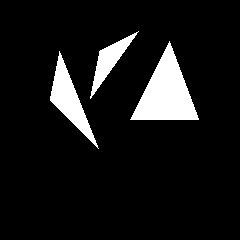

In [232]:
im = Image.new('RGB', im_size)
tri0 = triangle_2d((60,50),(50,100),(100,150))
tri1 = triangle_2d((100,50),(90,100),(140,30))
tri2 = triangle_2d((130,120),(200,120),(170,40))
tri0.render(im)
tri1.render(im)
tri2.render(im)
#tring.renderPoints(im)
im

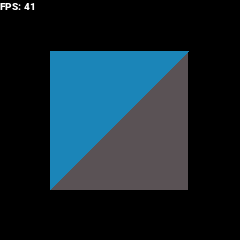

In [233]:
cube = loadObj('3d_models/cube.obj')
j = 0
i = 0
start_time = time.time()
render_time = 0
font = ImageFont.truetype('Roboto-Black.ttf')

for i in range(360):
    j += 1
    im = Image.new('RGB', im_size)
    draw = ImageDraw.Draw(im)
    clear_output(wait=True)
    cube.ang = (i,j)
    start_time = time.time()
    cube.render(im)
    render_time = time.time()-start_time
    draw.text((0,0),"FPS: "+str(int(1/render_time)),font=font)
    display(im)

1761664516.0646832

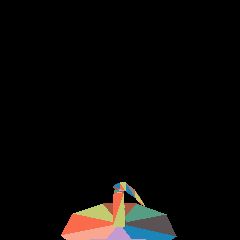

In [240]:
j = 0
i = 180
base = loadObj('3d_models/base.obj')
base.pos = (0,1,2)
base.colorPallet = [(155,113,88)]

trunk = loadObj('3d_models/sproutTrunk.obj')
trunk.pos = (0,1,2)
trunk.colorPallet = [(97,126,48)]

leaf = loadObj('3d_models/leaf2.obj')
leaf.pos = (0,0.8,2)
leaf.colorPallet = [(144,186,72)]

for j in range(360):
    im = Image.new('RGB', im_size)
    clear_output(wait=True)
    base.ang = (i,j)
    base.render(im)
    trunk.ang = (i,j)
    trunk.render(im)
    leaf.ang = (i,j)
    leaf.render(im)
    display(im)